
# Problem 5

This notebook extends the simple Bayesian regression model to a multiple regression model. The objective is to predict insurance charges based on a patient’s BMI, age, and number of children using Bayesian methods. The model includes an inverse-gamma prior for the noise parameter, a normal prior for the intercept, and a multivariate normal prior for the regression coefficients.


In [18]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import stan
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

import nest_asyncio
nest_asyncio.apply()


## Data Loading and Preprocessing

To predict insurance charges with Bayesian multiple regression, we begin by loading the dataset and focusing on the relevant features: BMI, age, number of children, and charges. These features are then standardized to have a mean of zero and a standard deviation of one, ensuring that differences in scale do not bias our model's performance. Standardizing the data facilitates model convergence and makes the interpretation of parameter estimates more intuitive. After standardization, the data is divided into a training set, which will be used to fit our model, and a test set, which will be reserved for evaluating the model's predictive performance.

In [19]:
# Load the dataset
data = pd.read_csv('insurance.csv')

# Selecting relevant columns
data = data[['bmi', 'age', 'children', 'charges']]

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the predictors and the outcome variable
scaled_features = scaler.fit_transform(data.drop('charges', axis=1))  # Standardize features
scaled_charges = scaler.fit_transform(data['charges'].values.reshape(-1, 1)).flatten()  # Standardize charges

# Create a DataFrame for the scaled features
scaled_data = pd.DataFrame(scaled_features, columns=['bmi', 'age', 'children'])
scaled_data['charges'] = scaled_charges

# Split the data into training and test sets
train_data, test_data = train_test_split(scaled_data, test_size=0.2, random_state=42)

## Bayesian Multiple Regression Model

The core of our Bayesian approach is the specification of the multiple regression model, which includes priors for the noise parameter (`sigma`), the intercept (`alpha`), and the regression coefficients (`beta`). The noise parameter follows an inverse-gamma distribution, reflecting our belief about the variability of insurance charges. The intercept and coefficients are drawn from normal and multivariate normal distributions, respectively. These priors are designed to express initial uncertainty in our estimates before observing the data.

In [20]:

vectorized_program_code = '''
data {
    int<lower=0> N; // number of data points
    int<lower=1> K; // number of predictors
    matrix[N, K] x; // matrix of predictors
    vector[N] y;    // outcome (insurance charges)

    // Hyperparameters for priors
    real<lower=0> tau_0;
    real<lower=0> tau_1;
    real<lower=0> sigma_alpha;
    vector<lower=0>[K] sigma_beta;
}

parameters {
    real alpha;            // intercept
    vector[K] beta;        // coefficients for predictors
    real<lower=0> sigma2;  // variance (sigma squared)
}

transformed parameters {
    real<lower=0> sigma;   // standard deviation
    sigma = sqrt(sigma2);
}

model {
    // Priors
    sigma ~ inv_gamma(tau_0, tau_1);
    alpha ~ normal(0, sigma_alpha);
    beta ~ multi_normal(rep_vector(0, K), diag_matrix(sigma_beta));
    
    // Likelihood
    y ~ normal(alpha + x*beta, sigma);
}
'''


## Model Fitting

With our model defined, we prepare the training data in the format expected by Stan, specifying the number of data points (N), the number of predictors (K), the standardized predictor matrix (x), and the standardized charges (y). The priors' hyperparameters are set to reasonable values based on the standardized data. We build and sample from the posterior using Stan's MCMC algorithm, yielding distributions for each parameter that encapsulate our updated beliefs after considering the data.

In [21]:
# Preparing data for Stan model
stan_data = {
    'N': train_data.shape[0],
    'K': 3,
    'x': train_data[['bmi', 'age', 'children']].values,
    'y': train_data['charges'].values,
    'tau_0': 0.01,
    'tau_1': 0.01,
    'sigma_alpha': 0.5,
    'sigma_beta': [0.5, 0.5, 0.5]
}

# Fitting the model
posterior = stan.build(vectorized_program_code, data=stan_data, random_seed=42)
fit = posterior.sample(num_chains=4, num_samples=2000, num_warmup=1000)



Building...



Building: 12.9s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 6.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.67 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the fo

#### Note
I am analyzing based on the assumption that the charges should also be scaled for predictive purposes. The predictors are then analyzed because we can tell even with everything scaled which predictors have the highest influence. If we wanted to perform further analysis on the insurance charges, we would have to inverse transform the data back to being pre-scaled for further analysis.

## Evaluation and Interpretation

In [22]:
summary = az.summary(fit)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.006,0.029,-0.048,0.060,0.0,0.0,9745.0,5936.0,1.0
beta[0],0.168,0.029,0.113,0.223,0.0,0.0,10557.0,6657.0,1.0
beta[1],0.256,0.029,0.203,0.309,0.0,0.0,9798.0,6480.0,1.0
beta[2],0.056,0.028,0.002,0.107,0.0,0.0,10192.0,6492.0,1.0
sigma2,0.882,0.038,0.809,0.952,0.0,0.0,10191.0,6133.0,1.0
sigma,0.939,0.020,0.901,0.977,0.0,0.0,10191.0,6133.0,1.0


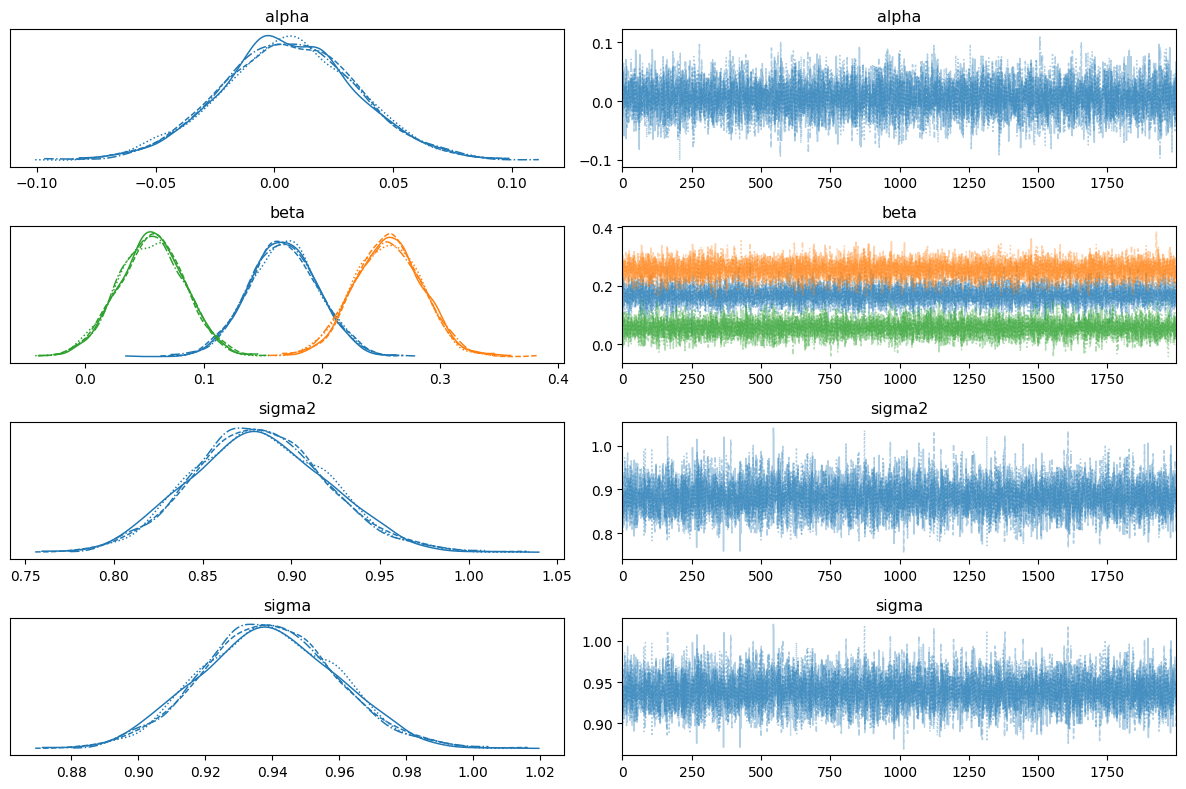

In [23]:
az.plot_trace(fit)
plt.tight_layout()

### Which of the three variables is the best predictor of Insurance Charges?

The best predictor can be identified by looking at the posterior mean estimates of the regression coefficients and their 94% highest density intervals (HDI). The predictor with the highest posterior mean and whose HDI does not cross zero would be considered the most significant predictor.

From the table:

- BMI (`beta[0]`): Mean = 0.168, HDI = [0.113, 0.223]
- Age (`beta[1]`): Mean = 0.256, HDI = [0.203, 0.309]
- Children (`beta[2]`): Mean = 0.056, HDI = [0.002, 0.107]

Age (`beta[1]`) has the highest mean estimate and its HDI is both the widest and farthest from zero, indicating the strongest and most reliable relationship with insurance charges. Thus, age is the best predictor of insurance charges among the three.

BMI (`beta[0]`) also has a significant positive relationship with insurance charges, given that its HDI does not include zero, but its impact is less than that of age.

The number of children (`beta[2]`) has the smallest effect size, and while its HDI does not include zero, indicating some level of significance, the relationship is comparatively weaker than BMI and age.

Hence, based on the Bayesian multiple regression analysis, **age** is the most significant predictor for insurance charges. This is followed by BMI, with the number of children being the least significant of the three.
